# SARIMAX model

### Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pmdarima
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Generating arbitrary data

In [2]:
dates = pd.date_range(start = '2000-01-01', periods = 12*24, freq = 'M')

cycle_sin = 2
cycle_cos = 4
resolution = len(dates)

length_sin = np.pi*2*cycle_sin
length_cos = np.pi*2*cycle_cos

wave_sin = np.sin(np.arange(0, length_sin, length_sin/resolution))
wave_cos = np.cos(np.arange(0, length_cos, length_cos/resolution))
wave_cos2 = 0.5*np.cos(np.arange(0, length_cos, length_cos/resolution))

data = pd.concat([pd.DataFrame(wave_sin), pd.DataFrame(wave_cos), pd.DataFrame(wave_cos2)], axis = 1)
data.index = dates
data.columns = ['sin_t', 'cos_t', 'cos_1/2t']
data.head()

,sin_t,cos_t,cos_1/2t
2000-01-31,0.000000,1.000000,0.500000
2000-02-29,0.043619,0.996195,0.498097
2000-03-31,0.087156,0.984808,0.492404
2000-04-30,0.130526,0.965926,0.482963
2000-05-31,0.173648,0.939693,0.469846


<AxesSubplot:title={'center':'Periodic signal'}, xlabel='Time [M]', ylabel='y'>

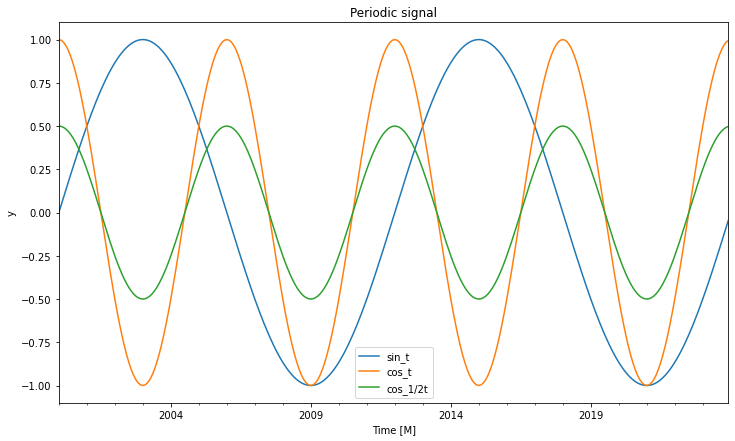

In [3]:
data.plot(figsize = (12,7), title = 'Periodic signal', xlabel = 'Time [M]', ylabel = 'y')

<AxesSubplot:title={'center':'Correlation matrix'}>

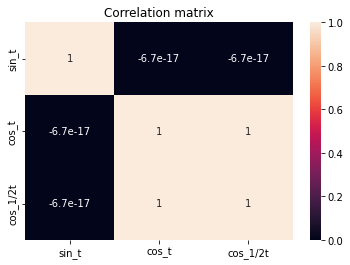

In [4]:
plt.figure()
plt.title('Correlation matrix')
sns.heatmap(data.corr(), annot=True)

### Data split

In [5]:
data_exo = data[['cos_t', 'cos_1/2t']]
data_train = data['sin_t'].iloc[:-12]
data_test = data['sin_t'].iloc[-12:]

### Inititate the model

In [6]:
model = pmdarima.auto_arima(data_train, exogeneous = data_exo.iloc[:len(data_train),:],
                            m = 12, random_state = 42, n_jobs = -1, 
                            start_p = 0, max_p = 2, 
                            start_P = 0, max_P = 0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  276
Model:               SARIMAX(2, 1, 2)   Log Likelihood                2899.623
Date:                Wed, 10 Apr 2024   AIC                          -5787.245
Time:                        13:58:01   BIC                          -5765.545
Sample:                    01-31-2000   HQIC                         -5778.536
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.393e-19   1.09e-05   5.88e-14      1.000   -2.13e-05    2.13e-05
ar.L1          1.9980      0.000   6185.084      0.000       1.997       1.999
ar.L2         -0.9999   4.06e-05  -2.47e+04      0.000      -1.000      -1.000
ma.L1          0.0082   3.24e-08   2.52e+05      0.000       0.008       0.008
ma.L2          0.0108   3.48e-08   3.12e+05      0.000       0.011       0.011
sigma2          1e-10   1.55e-10      0.644      0.520   -2.05e-10    4.05e-10
===================================================================================
Ljung-Box (L1) (Q):                   3.09   Jarque-Bera (JB):            479089.43
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            13.30
Prob(H) (two-sided):                  0.00   Kurtosis:                       205.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.3e+23. Standard errors may be unstable.
"""

In [7]:
model.params

<bound method ARIMA.params of ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)>

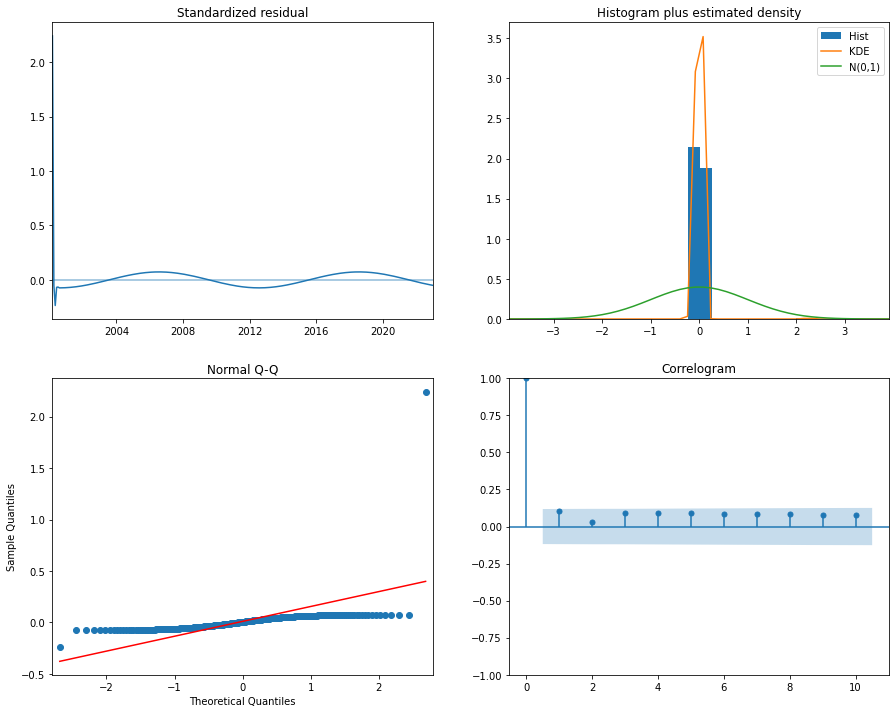

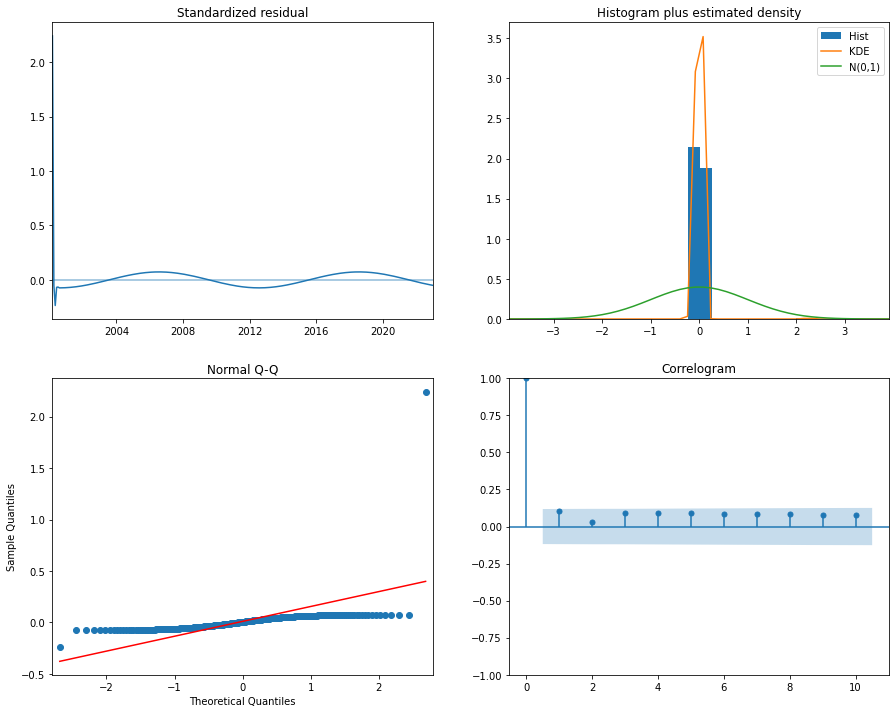

In [8]:
model.plot_diagnostics(figsize=(15,12))

### Make predictions

In [9]:
preds_train = model.predict(n_periods = len(data_train), 
                            exogenous = data_exo.iloc[len(data_train):,:], 
                            n_jobs = -1)

mse_train = mean_squared_error(data_train, preds_train)
print('Mean Squared Error - Train:', mse_train)

preds_test = model.predict(n_periods = len(data_test), 
                            exogenous = data_exo.iloc[len(data_test):,:], 
                            n_jobs = -1)

mse_test = mean_squared_error(data_test, preds_test)
print('Mean Squared Error - Test:', mse_test)

Mean Squared Error - Train: 0.1463617913469884
Mean Squared Error - Test: 8.624567315864512e-09


<AxesSubplot:title={'center':'Prediction for train'}, xlabel='Time [M]', ylabel='y'>

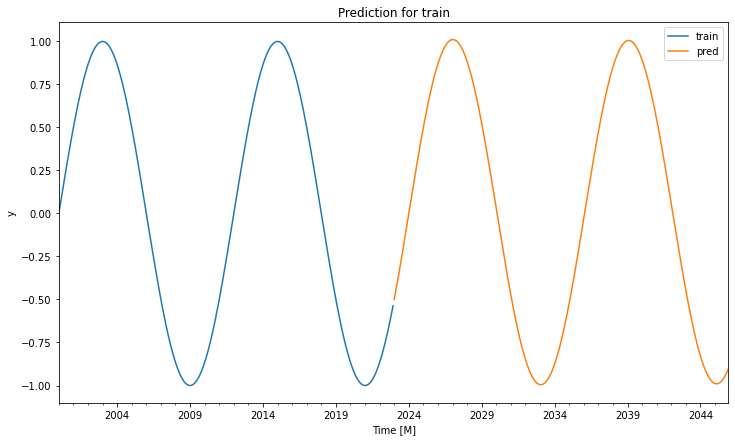

In [10]:
pd.DataFrame({'train': data_train, 'pred': preds_train}).plot(figsize = (12,7), 
                                                              title = 'Prediction for train',
                                                              xlabel = 'Time [M]',
                                                              ylabel = 'y')

<AxesSubplot:title={'center':'Prediction for test'}, xlabel='Time [M]', ylabel='y'>

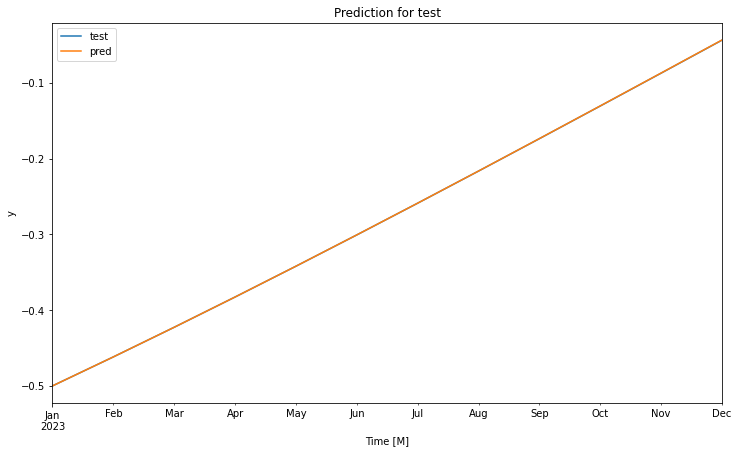

In [11]:
pd.DataFrame({'test': data_test, 'pred': preds_test}).plot(figsize = (12,7), 
                                                           title = 'Prediction for test',
                                                           xlabel = 'Time [M]',
                                                           ylabel = 'y')